# ensemble 多模型融合
### 思路是通过各个模型(GlobalAveragePooling层)提取特征，利用分类器(Dense)将特征做分类

In [1]:
train_data_dir      = '../data/train'
validation_data_dir = '../data/validation'

In [10]:
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

X = np.zeros((2000, 299, 299, 3), dtype=np.uint8)
y = np.zeros((2000,), dtype=np.uint8)

cats = glob('../data/train/cats/*.jpg')
dogs = glob('../data/train/dogs/*.jpg')
# print(len(cats))

for i in tqdm(range(1000)):
    X[i] = cv2.resize(cv2.imread(cats[i]), (299, 299))
    X[i+1000] = cv2.resize(cv2.imread(dogs[i]), (299, 299))
y[1000:] = 1

100%|██████████| 1000/1000 [00:08<00:00, 115.66it/s]


In [78]:
def get_X(n, width, height):
    import cv2
    import numpy as np
    from glob import glob
    
    TX = np.zeros((n, width, height, 3), dtype=np.uint8)
    ty = np.zeros((n,), dtype=np.uint8)

    cats = glob('../data/train/cats/*.jpg')
    dogs = glob('../data/train/dogs/*.jpg')
    # print(len(cats))

    for i in tqdm(range(n//2)):
        TX[i] = cv2.resize(cv2.imread(cats[i]), (width, height))
        TX[i+n//2] = cv2.resize(cv2.imread(dogs[i]), (width, height))
    ty[n//2:] = 1
    
    return (TX, ty)

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# img_width, img_height = 299, 299

# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255.)


def generator(width, height, batch_size=16):
    # automagically retrieve images and their classes for train and validation sets
    train_generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(width, height),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(width, height),
            batch_size=batch_size,
            class_mode='categorical')
    return train_generator, validation_generator

Using TensorFlow backend.


In [14]:
from keras.models import Model, Input
from keras.optimizers import SGD
from keras.applications import InceptionV3, VGG16, Xception
from keras.layers import Lambda, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

# 模型一：Xception

In [4]:
train_gen, valid_gen = generator(299, 299)
e_X, e_y = next(train_gen)
print(e_X.shape, e_y.shape)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
(16, 299, 299, 3) (16, 2)


In [8]:
e_X2 = next(train_gen)[0]
print(e_X2.shape)

(16, 299, 299, 3)


In [52]:
from keras.applications.xception import preprocess_input

cnn_model_1 = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

inputs = Input((299, 299, 3))
x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model_1(x)
x = GlobalAveragePooling2D()(x)
cnn_model_1 = Model(inputs, outputs=x)

features = cnn_model_1.predict(X, batch_size=16, verbose=1)

2000/2000 [==============================] - 34s    


# 模型二：InceptionV3

In [15]:
from keras.models import Input
from keras.applications.inception_v3 import preprocess_input

cnn_model_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

inputs = Input((299, 299, 3))
x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model_2(x)
x = GlobalAveragePooling2D()(x)
cnn_model_2 = Model(inputs, outputs=x)

features = cnn_model_2.predict(X, batch_size=16, verbose=1)

2000/2000 [==============================] - 24s    


In [17]:
print(type(features), '\n', features.shape)

<class 'numpy.ndarray'> 
 (2000, 2048)


In [18]:
print(features[0])

[ 0.25792938  0.37510553  0.20530717 ...,  1.15567482  0.30231705
  0.36135691]


In [19]:
img = features[0].reshape(32, 64)
img

array([[ 0.25792938,  0.37510553,  0.20530717, ...,  0.84036177,
         0.9824723 ,  0.26641583],
       [ 0.33179253,  0.96044314,  0.42132959, ...,  0.4557794 ,
         0.24284518,  0.31381416],
       [ 0.28212824,  0.06813684,  0.30000365, ...,  0.64237094,
         0.26876482,  0.5836404 ],
       ..., 
       [ 0.38736504,  0.05536069,  0.08977319, ...,  0.24165502,
         0.50935465,  0.21360375],
       [ 0.08103947,  1.51397622,  0.49253169, ...,  0.31299123,
         0.98050171,  0.28557312],
       [ 0.03182287,  0.05775777,  0.09761576, ...,  1.15567482,
         0.30231705,  0.36135691]], dtype=float32)

In [21]:
print(X[0].shape)

(299, 299, 3)


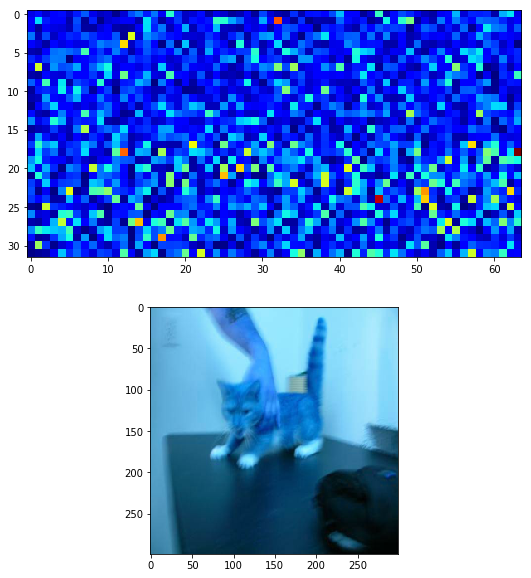

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,1,figsize=(10,10))
ax =axes.flatten()
ax[0].imshow(img,cmap='jet')
ax[1].imshow(X[0])

In [23]:
from keras.models import Input
from keras.applications.inception_v3 import preprocess_input

cnn_model_3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

inputs = Input((299, 299, 3))
x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model_3(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
cnn_model_3 = Model(inputs, outputs=x)

features_2 = cnn_model_3.predict(X, batch_size=16, verbose=1)

2000/2000 [==============================] - 23s    


In [24]:
print(features_2.shape)

(2000, 1024)


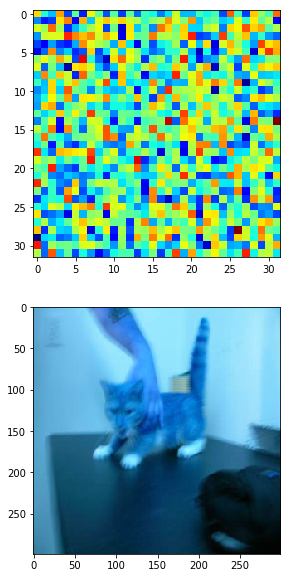

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,1,figsize=(10,10))
ax =axes.flatten()
ax[0].imshow(features_2[0].reshape(32,32),cmap='jet')
ax[1].imshow(X[0])

In [33]:
from keras.models import Input
from keras.applications.inception_v3 import preprocess_input

cnn_model_4 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

inputs = Input((299, 299, 3))
x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model_4(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
cnn_model_4 = Model(inputs, outputs=x)

features_3 = cnn_model_4.predict(X, batch_size=16, verbose=1)

2000/2000 [==============================] - 24s    


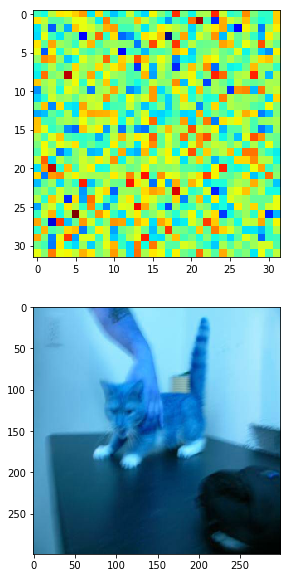

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,1,figsize=(10,10))
ax =axes.flatten()
ax[0].imshow(features_3[0].reshape(32,32),cmap='jet')
ax[1].imshow(X[0])

#### 由此看来，特征图并得不到什么信息

# 搭建并训练全连接分类器模型

### 利用imagenet预训练模型权重抽取特征，将该特征拿来分类，训练分类器的准确率

In [53]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
x_model = Model(inputs, x)
x_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
h = x_model.fit(features, y, batch_size=16, epochs=50, validation_split=0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 3s - loss: 0.2724 - acc: 0.9012 - val_loss: 0.1439 - val_acc: 0.9925
Epoch 2/50
1600/1600 [==============================] - 0s - loss: 0.0807 - acc: 0.9900 - val_loss: 0.1038 - val_acc: 0.9875
Epoch 3/50
1600/1600 [==============================] - 0s - loss: 0.0533 - acc: 0.9906 - val_loss: 0.0745 - val_acc: 0.9875
Epoch 4/50
1600/1600 [==============================] - 0s - loss: 0.0411 - acc: 0.9919 - val_loss: 0.0525 - val_acc: 0.9875
Epoch 5/50
1600/1600 [==============================] - 0s - loss: 0.0350 - acc: 0.9950 - val_loss: 0.0521 - val_acc: 0.9875
Epoch 6/50
1600/1600 [==============================] - 0s - loss: 0.0322 - acc: 0.9925 - val_loss: 0.0530 - val_acc: 0.9875
Epoch 7/50
1600/1600 [==============================] - 0s - loss: 0.0267 - acc: 0.9950 - val_loss: 0.0359 - val_acc: 0.9900
Epoch 8/50
1600/1600 [==============================] - 0s - loss: 0.0217 - ac

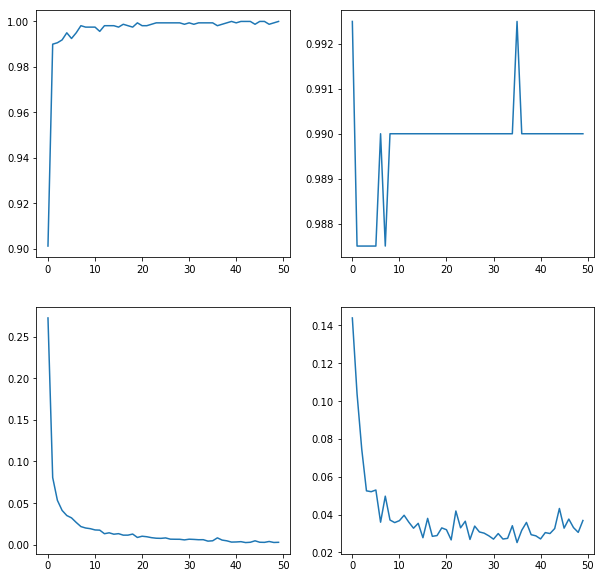

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,2,figsize=(10,10))
ax = axes.flatten()

x_his = x_model.history
x_log = x_his.history


ax[0].plot(range(50), x_log['acc'])
ax[1].plot(range(50), x_log['val_acc'])
ax[2].plot(range(50), x_log['loss'])
ax[3].plot(range(50), x_log['val_loss'])

In [60]:
# 测试集的特征向量
features_test = cnn_model_1.predict(X_test, batch_size=64, verbose=1)

12500/12500 [==============================] - 197s   


In [61]:
# 预测测试集的类别
y_pred2 = x_model.predict(features_test, batch_size=64)

In [62]:
# 生成提交文件，提交预测结果
import pandas as pd

df = pd.read_csv('../sample_submission.csv')
df['label'] = y_pred2.clip(min=0.005, max=0.995)
df.to_csv('pred2.csv', index=None)

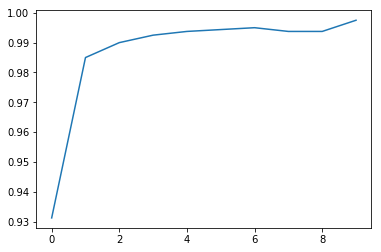

In [45]:
plt.plot(range(10), lo['acc'])

In [46]:
n = 12500
X_test = np.zeros((n, 299, 299, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('../test1/%d.jpg' % (i+1)), (299, 299))

100%|██████████| 12500/12500 [01:00<00:00, 207.58it/s]


In [48]:
features_test = cnn_model_2.predict(X_test, batch_size=16, verbose=1)

12500/12500 [==============================] - 135s   


In [49]:
y_pred = model.predict(features_test, batch_size=64)

In [51]:
import pandas as pd

df = pd.read_csv('../sample_submission.csv')
df['label'] = y_pred.clip(min=0.005, max=0.995)
df.to_csv('pred.csv', index=None)

In [50]:
import pandas as pd

df = pd.read_csv('../sample_submission.csv')
df['label'] = y_pred.clip(min=0.005, max=0.995)
df.to_csv('pred.csv.gz', index=None, compression='gzip')

# 多模型融合
### 融合InceptionV3和Xception

In [64]:
# 定义一个特征抽取器
def get_features(MODEL, width, height, data=X, weights='imagenet'):
    from keras.models import Model, Input
    from keras.layers import Lambda, GlobalAveragePooling2D
    
    cnn_model = MODEL(weights=weights, include_top=False, input_shape=(width, height, 3))
    inputs = Input((width, height, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    
    features = cnn_model.predict(data, batch_size=32, verbose=1)
    return features

In [70]:
from keras.applications import InceptionV3, Xception, VGG16, ResNet50

inception_features = get_features(InceptionV3, 299, 299, X)
xception_features  = get_features(Xception, 299, 299, X)
# inc_resv2_features = get_features(InceptionResNetV2, 299, 299, X)

2000/2000 [==============================] - 36s    


In [80]:
vgg16_features     = get_features(VGG16, 224, 224, get_X(2000, 224, 224)[0])
resnet50_features  = get_features(ResNet50, 224, 224, get_X(2000, 224, 224)[0])

100%|██████████| 1000/1000 [00:08<00:00, 115.58it/s]


2000/2000 [==============================] - 18s    

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 167.22it/s]


2000/2000 [==============================] - 20s    


### 打印看看特征维度  

In [81]:
print('inception_features shape:', inception_features.shape, '\n')
print('xception_features shape:', xception_features.shape, '\n')
print('vgg16_features shape:', vgg16_features.shape, '\n')
print('resnet50_features shape:', resnet50_features.shape, '\n')

inception_features shape: (2000, 2048) 

xception_features shape: (2000, 2048) 

vgg16_features shape: (2000, 512) 

resnet50_features shape: (2000, 2048) 



### 融合特征

In [83]:
features = np.concatenate([inception_features, xception_features, vgg16_features, resnet50_features], axis=-1)
print(features.shape)

(2000, 6656)


In [85]:
%%time
# 将特征使用h5py保存为hdf5格式
import h5py

with h5py.File('features', 'w') as d:
    d['features'] = features

CPU times: user 0 ns, sys: 63.4 ms, total: 63.4 ms
Wall time: 149 ms


In [ ]:
# 读入特征
import h5py

with h5py.File('features', 'r') as d:
    features = np.array(d['features'])

# 构建模型

In [86]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
x_model = Model(inputs, x)
x_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
h = x_model.fit(features, y, batch_size=32, epochs=20, validation_split=0.3)

Train on 1400 samples, validate on 600 samples
Epoch 1/20
1400/1400 [==============================] - 5s - loss: 0.2937 - acc: 0.8936 - val_loss: 0.1232 - val_acc: 0.9950
Epoch 2/20
1400/1400 [==============================] - 0s - loss: 0.0552 - acc: 0.9907 - val_loss: 0.0774 - val_acc: 0.9933
Epoch 3/20
1400/1400 [==============================] - 0s - loss: 0.0381 - acc: 0.9936 - val_loss: 0.0470 - val_acc: 0.9950
Epoch 4/20
1400/1400 [==============================] - 0s - loss: 0.0271 - acc: 0.9986 - val_loss: 0.0445 - val_acc: 0.9950
Epoch 5/20
1400/1400 [==============================] - 0s - loss: 0.0200 - acc: 0.9993 - val_loss: 0.0408 - val_acc: 0.9950
Epoch 6/20
1400/1400 [==============================] - 0s - loss: 0.0183 - acc: 0.9979 - val_loss: 0.0332 - val_acc: 0.9950
Epoch 7/20
1400/1400 [==============================] - 0s - loss: 0.0148 - acc: 0.9986 - val_loss: 0.0290 - val_acc: 0.9950
Epoch 8/20
1400/1400 [==============================] - 0s - loss: 0.0135 - ac

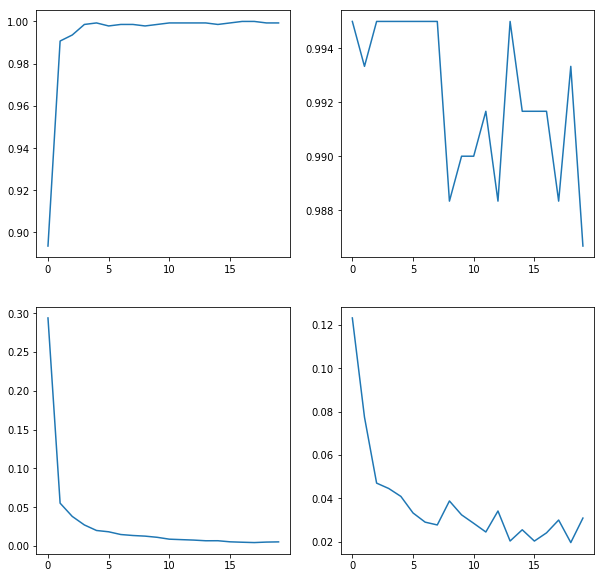

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

f,axes = plt.subplots(2,2,figsize=(10,10))
ax = axes.flatten()

his = x_model.history
log = his.history


ax[0].plot(range(20), log['acc'])
ax[1].plot(range(20), log['val_acc'])
ax[2].plot(range(20), log['loss'])
ax[3].plot(range(20), log['val_loss'])

In [90]:
def get_X_test(n, width, height):
    X_test = np.zeros((n, width, height, 3), dtype=np.uint8)

    for i in tqdm(range(n)):
        X_test[i] = cv2.resize(cv2.imread('../test1/%d.jpg' % (i+1)), (width, height))
    return X_test

In [91]:
ince_features_test = get_features(InceptionV3, 299, 299, X_test)
xcep_features_test = get_features(Xception, 299, 299, X_test)

vgg16_features_test = get_features(VGG16, 224, 224, get_X_test(12500, 224, 224))
resnet50_features_test = get_features(ResNet50, 224, 224, get_X_test(12500, 224, 224))

12500/12500 [==============================] - 204s   

  0%|          | 26/12500 [00:00<00:49, 252.25it/s]

100%|██████████| 12500/12500 [00:55<00:00, 223.65it/s]


12500/12500 [==============================] - 94s    

  0%|          | 24/12500 [00:00<00:54, 228.25it/s]

100%|██████████| 12500/12500 [00:56<00:00, 222.07it/s]


12500/12500 [==============================] - 101s   


In [92]:
features_test = np.concatenate([ince_features_test, xcep_features_test, 
                                vgg16_features_test, resnet50_features_test], axis=-1)
print(features.shape)

(2000, 6656)


In [94]:
y_pred = x_model.predict(features_test, batch_size=64)

In [95]:
# 生成提交文件，提交预测结果
import pandas as pd

df = pd.read_csv('../sample_submission.csv')
df['label'] = y_pred.clip(min=0.005, max=0.995)
df.to_csv('pred3.csv', index=None)